In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import datetime as dt
import numpy
import scipy.stats as st
import gmaps
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
#Read Excel
df=pd.read_excel("./Business_dataset.xlsx")
df.head()

,Order ID,Generic Name,Brand Name,Company Name,Disease Medical Use,Invoice date,Company code,ship to country,Sold-to party Country Full Name,Delivery Plant,External Agent,Sales quantity,Price TC /Kg,Revenue,External commissions,Months
0,FY-2015-001,Aripiprazole,Abilify,Generic,Psychosis; depression,2015-11-09,5704,Mexico,Mexico,8370,Not assigned,450,204,91800,0.0,Nov
1,IN-2015-002,Oxycodone,OxyContin,Generic,Pain,2015-06-30,5704,Thailand,Thailand,8370,Not assigned,374,472,176528,0.0,Jun
2,IN-2015-003,Oxycodone,OxyContin,Generic,Pain,2015-12-05,5704,Vietnam,Japan,8370,Assigned,138,472,65136,4186.0,Dec
3,IN-2015-004,Oxycodone,OxyContin,Generic,Pain,2015-05-09,5704,Australia,Australia,8370,Not assigned,227,472,107144,0.0,May
4,IN-2015-005,Oxycodone,OxyContin,Generic,Pain,2015-07-09,5704,Singapore,Singapore,8370,Not assigned,394,472,185968,0.0,Jul


In [3]:
#Data cleaning-dropna(), Adding Broad Category column for diseases, Reducing Company Name Length, drop unnecessary columns 
#for the research, rearrange order of columns based on relevance
df=df.dropna()
df["Broad Category Diseases"]=df["Disease Medical Use"]
df["Broad Category Diseases"]=df["Broad Category Diseases"].replace({
    "Crohn's disease rheumatoid arthritis": "Arthritis", 
    "Non-Hodgkin’s lymphoma; rheumatoid arthritis":"Arthritis",
    "Crohn's disease; Rheumatoid arthritis":"Arthritis",
    "Osteoarthritis; rheumatoid arthritis": "Arthritis",
    "Rheumatoid arthritis": "Arthritis", 
    "Psychosis; depression": "Depression",
    "Depression; anxiety disorders":"Depression",
    "Diabetes mellitus type 2":"Diabetes",
    "Diabetes mellitus type 1 and 2":"Diabetes"})

del df["Delivery Plant"]
del df["External Agent"]
del df["External commissions"]
del df["Company code"]

df.columns
df=df[['Invoice date','Brand Name', 'Company Name',
       'Disease Medical Use',  'Broad Category Diseases','Months',
        'Sold-to party Country Full Name', 'Sales quantity',
       'Price TC /Kg', 'Revenue','ship to country','Generic Name', 'Order ID']]
df.head()

,Invoice date,Brand Name,Company Name,Disease Medical Use,Broad Category Diseases,Months,Sold-to party Country Full Name,Sales quantity,Price TC /Kg,Revenue,ship to country,Generic Name,Order ID
0,2015-11-09,Abilify,Generic,Psychosis; depression,Depression,Nov,Mexico,450,204,91800,Mexico,Aripiprazole,FY-2015-001
1,2015-06-30,OxyContin,Generic,Pain,Pain,Jun,Thailand,374,472,176528,Thailand,Oxycodone,IN-2015-002
2,2015-12-05,OxyContin,Generic,Pain,Pain,Dec,Japan,138,472,65136,Vietnam,Oxycodone,IN-2015-003
3,2015-05-09,OxyContin,Generic,Pain,Pain,May,Australia,227,472,107144,Australia,Oxycodone,IN-2015-004
4,2015-07-09,OxyContin,Generic,Pain,Pain,Jul,Singapore,394,472,185968,Singapore,Oxycodone,IN-2015-005


In [4]:
#Basic Stats-Average order qty, Average Drug price, Average Total Revenue, Total Qty
total_revenue=df.groupby("Brand Name").sum()["Revenue"]
total_qty=df.groupby("Brand Name").sum()["Sales quantity"]
avg_price=df.groupby("Brand Name").mean()["Price TC /Kg"]
avg_order_qty=df.groupby("Brand Name").mean()["Sales quantity"].map("{:.2f}".format)

summary_stats=pd.DataFrame({"Total Revenue":total_revenue,
    "Total Qty Sold":total_qty,
    "Average Price of Drug/Kg":avg_price,
    "Average Quantity per Order":avg_order_qty})
summary_stats =summary_stats.sort_values("Total Revenue", ascending=False)
summary_stats=summary_stats.reset_index()
summary_stats

,Brand Name,Total Revenue,Total Qty Sold,Average Price of Drug/Kg,Average Quantity per Order
0,Lyrica,193295500,386591,500.0,258.59
1,Nexium,34679964,94754,366.0,242.34
2,Copaxone,27107355,60105,451.0,241.39
3,Lantus Solostar,18472146,79966,231.0,263.05
4,Remicade,17388064,55376,314.0,255.19
5,Avastin,17385921,71547,243.0,269.99
6,"Rituxan, MabThera",9694412,26633,364.0,251.25
7,OxyContin,6822288,14454,472.0,244.98
8,Cymbalta,5344947,11799,453.0,235.98
9,Spiriva,4295670,13857,310.0,256.61


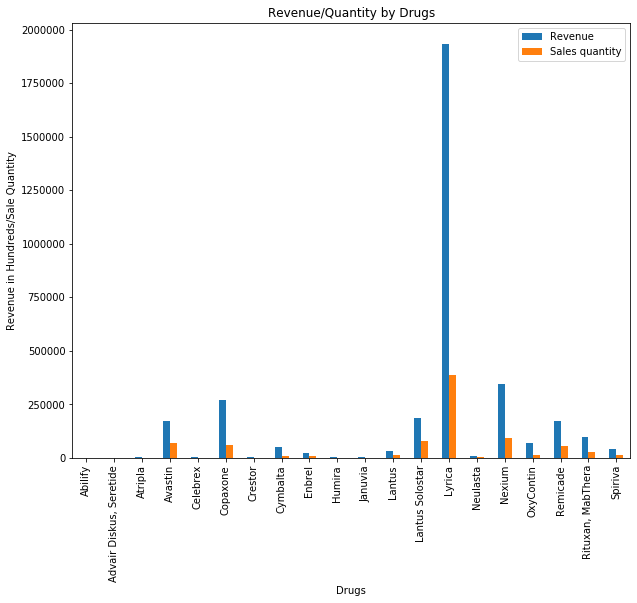

In [5]:

df_qty_grouped=df.groupby("Brand Name").sum()["Sales quantity"]
df_grouped=df.groupby("Brand Name").sum()["Revenue"]
df1 = pd.DataFrame(df_grouped/100).reset_index()
df2 = pd.DataFrame(df_qty_grouped).reset_index()
cmpD = df1.merge(df2, on='Brand Name').set_index('Brand Name')
cmpD.plot(kind='bar', figsize=(10,8))
plt.title("Revenue/Quantity by Drugs")
plt.xlabel("Drugs")
plt.ylabel("Revenue in Hundreds/Sale Quantity")
plt.show()

In [6]:

company_grouped=df.groupby("Company Name").sum()["Revenue"]
company_grouped=pd.DataFrame(company_grouped)
company_grouped=company_grouped.rename(index={"Centocor Ortho Biotech, Inc., Mitsubishi Tanabe Pharma": "Centocor Ortho Biotech",
                              "Biogen Idec, Chugai Pharmaceutical, Genentech/Roche":"Chugai Pharmaceutical"})

company_grouped

,Revenue
Company Name,
AbbVie,369591
Amgen,3146370
"AstraZeneca, Shionogi",337823
Chugai Pharmaceutical,9694412
Boehringer Ingelheim,4295670
Centocor Ortho Biotech,17388064
Genentech/Roche,17385921
Generic,74490590
"Gilead Sciences, Inc.",267117


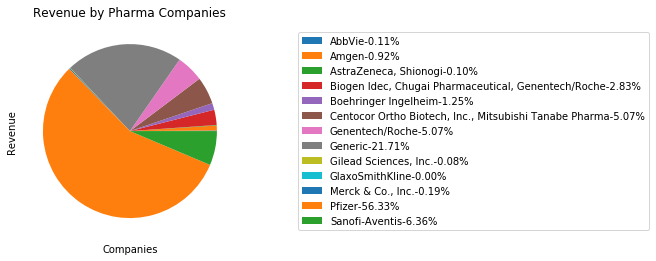

In [7]:
#Pie of company share in revenue terms
company_grouped=df.groupby("Company Name").sum()["Revenue"]
company_grouped=pd.DataFrame(company_grouped)
company_grouped=company_grouped.reset_index()
x=company_grouped["Revenue"]
fig1,axe =plt.pie(x)
plt.xlabel("Companies")
plt.title("Revenue by Pharma Companies")
a=company_grouped["Company Name"]
perc=(x/x.sum())*100
labels=["{0}-{1:1.2f}%".format(i,j) for i,j in zip(a, perc)]
plt.legend(fig1, labels, loc='center left', bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Revenue")
plt.show()

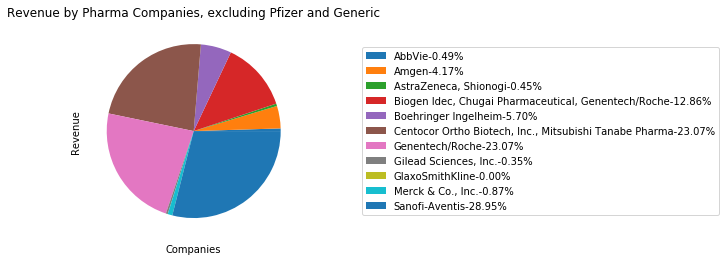

In [8]:
#Without Pfizer
new_grouped=company_grouped.loc[(company_grouped["Company Name"]!= "Pfizer")  & (company_grouped["Company Name"]!= "Generic")]
x=new_grouped["Revenue"]
fig2,axe =plt.pie(x)
plt.xlabel("Companies")
plt.title("Revenue by Pharma Companies, excluding Pfizer and Generic")
a=new_grouped["Company Name"]
perc=(x/x.sum())*100
labels=["{0}-{1:1.2f}%".format(i,j) for i,j in zip(a, perc)]
plt.legend(fig2, labels, loc='center left', bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Revenue")
plt.show()

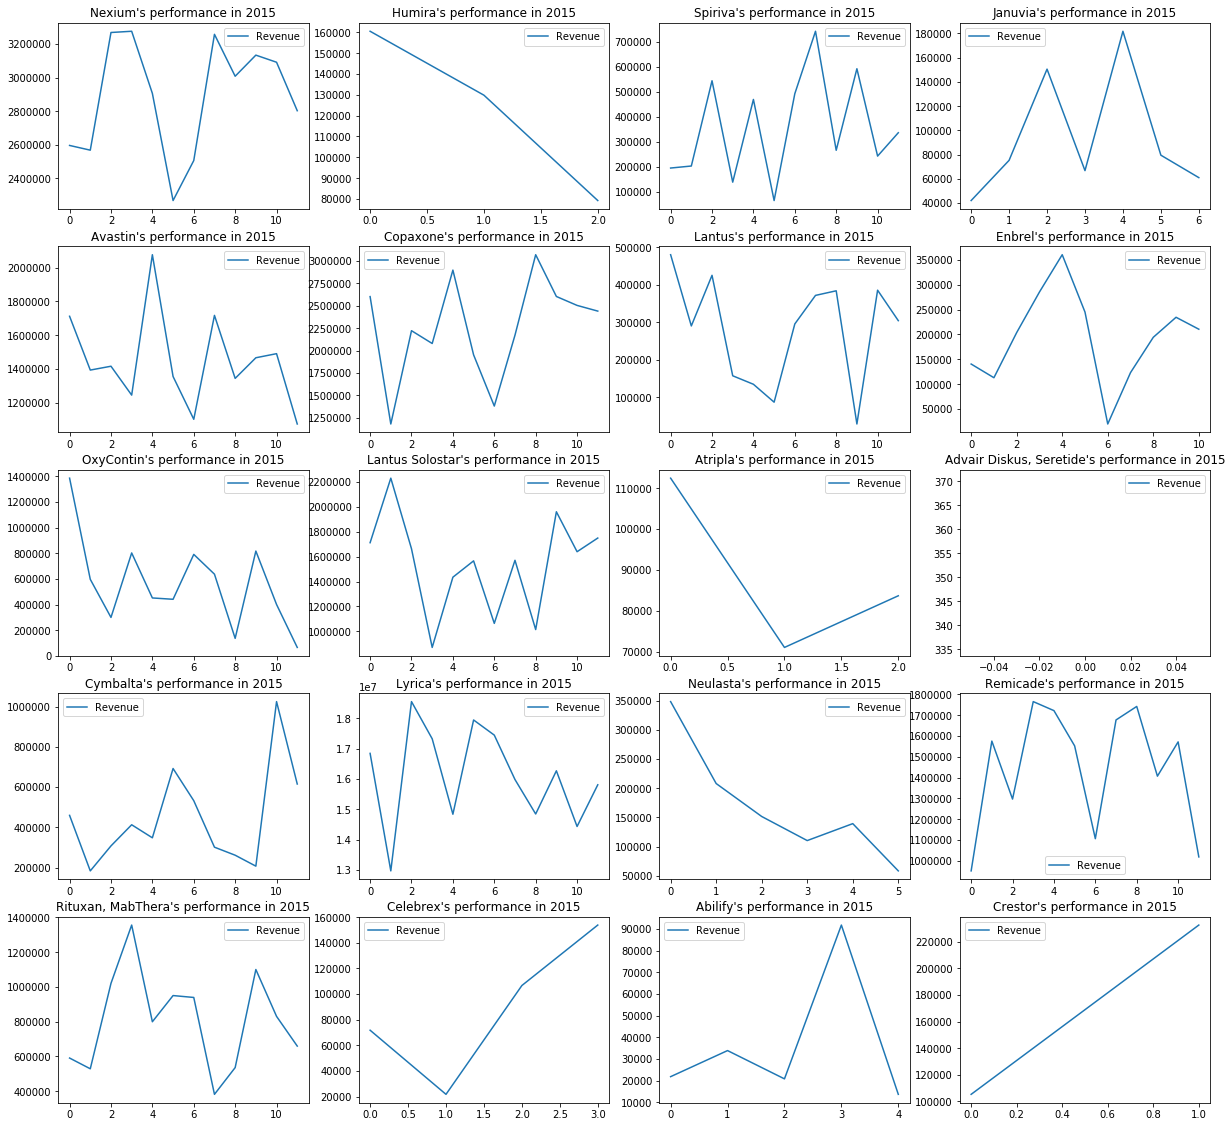

In [9]:
#Annual Performance Line chart of each drug 
month_grouped=df.groupby([ "Brand Name", "Months"]).sum()["Revenue"]
month_grouped=pd.DataFrame(month_grouped)
month_grouped=month_grouped.reset_index()
month_grouped["Months"]=pd.to_datetime(month_grouped.Months,format='%b', errors='coerce').dt.month
month_grouped=month_grouped.sort_values(by="Months")

month_grouped["Brand Name"].unique()
all_drugs=['Nexium', 'Humira', 'Spiriva', 'Januvia', 'Avastin', 'Copaxone',
        'Lantus', 'Enbrel', 'OxyContin', 'Lantus Solostar', 'Atripla',
        'Advair Diskus, Seretide', 'Cymbalta', 'Lyrica', 'Neulasta',
        'Remicade', 'Rituxan, MabThera', 'Celebrex', 'Abilify', 'Crestor']

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(80,60))
plt.subplots_adjust(left=0.2, right=1, bottom=0.5, top=1.5)
i=0
a=0
for drug in all_drugs:
    drug_df=month_grouped.loc[month_grouped["Brand Name"]==drug]
    plotname=drug+"_plot"
    plotname=drug_df.plot(x="Months", y="Revenue", title=drug+"'s performance in 2015", figsize=(20,15), ax=ax[a,i]
                          , use_index=False)
    if i == 3:
        i=0
        a+=1
    else:
        i+=1
plt.show()

In [10]:
#Grouping by disease
drug_disease_grouped=df.groupby(["Broad Category Diseases", "Brand Name", "Months"]).sum()["Revenue"]
drug_disease_grouped=pd.DataFrame(drug_disease_grouped).reset_index()
drug_disease_grouped=drug_disease_grouped.loc[drug_disease_grouped["Broad Category Diseases"]== "Arthritis"]
#Changing months into numbers
drug_disease_grouped["Months"] = pd.to_datetime(drug_disease_grouped.Months, format='%b', errors='coerce').dt.month
drug_disease_grouped = drug_disease_grouped.sort_values(by="Months")

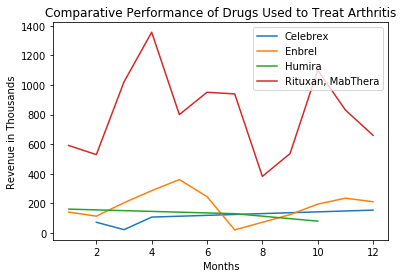

<Figure size 3600x2160 with 0 Axes>

In [11]:
#Plotting
drugs=['Celebrex', 'Enbrel', 'Humira', 'Rituxan, MabThera']
for drug in drugs:
    dfname=drug+"_df"
    dfname=drug_disease_grouped.loc[drug_disease_grouped["Brand Name"]== drug]
    plotname=drug+", "
    plotname=plt.plot(dfname["Months"], dfname["Revenue"]/1000, label=drug)
plt.title("Comparative Performance of Drugs Used to Treat Arthritis")
plt.xlabel("Months")
plt.ylabel("Revenue in Thousands")
plt.legend(loc="upper right")
plt.figure(figsize=(50,30))
plt.show()   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


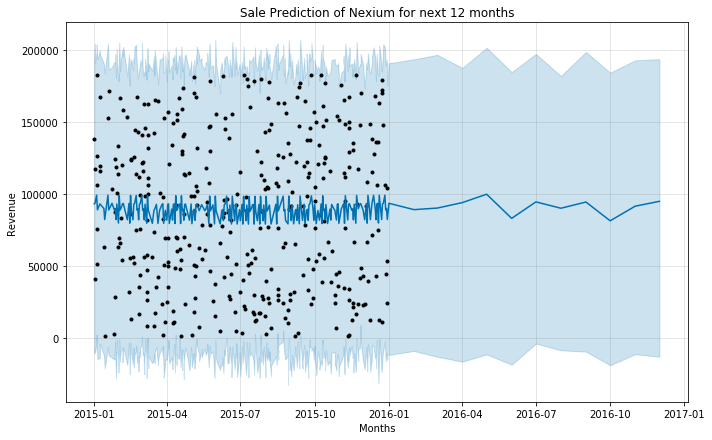

In [12]:
#Facebook's Prophet model for prediction
drug_name="Nexium"
df2=df[["Invoice date", "Brand Name", "Revenue"]]
df2=df2.loc[df2["Brand Name"]==drug_name]

predic_df=df2[["Invoice date", "Revenue"]]
predic_df=predic_df[["Invoice date", "Revenue"]].rename(columns={"Invoice date":"ds", "Revenue": "y"})
predic_model=Prophet(interval_width=0.95, weekly_seasonality=True)
predic_model.fit(predic_df)
forecast_df=predic_model.make_future_dataframe(periods=12, freq='MS')
forecast_df=predic_model.predict(forecast_df)
predic_model.plot(forecast_df, xlabel="Months", ylabel="Revenue")
plt.title("Sale Prediction of "+drug_name+" for next 12 months")
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


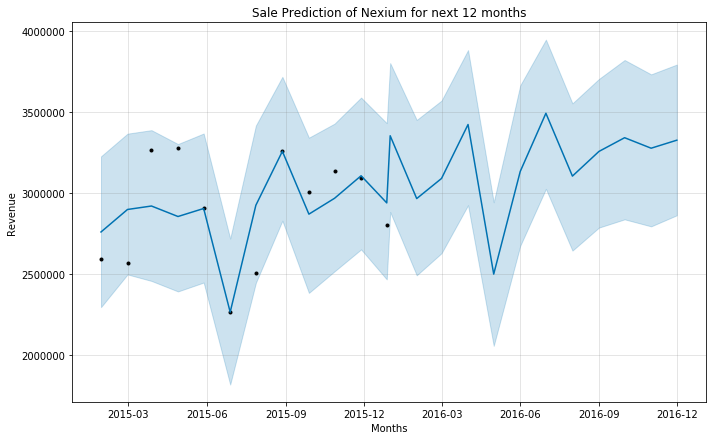

In [13]:
drug_name="Nexium"

df2=month_grouped.loc[month_grouped["Brand Name"]=="Nexium"]
df2["Months"]=df2["Months"].replace({ 1:"1/28/2015",  2:"2/28/2015",  3:"3/28/2015",  4:"4/28/2015",  5:"5/28/2015",  6:"6/28/2015",  
                                     7:"7/28/2015",  8:"8/28/2015",  9:"9/28/2015", 10:"10/28/2015", 11:"11/28/2015", 12:"12/28/2015"})

predic_df=df2[["Months", "Revenue"]]
predic_df=predic_df[["Months", "Revenue"]].rename(columns={"Months":"ds", "Revenue": "y"})
predic_model=Prophet(interval_width=0.95, weekly_seasonality=True)
predic_model.fit(predic_df)
forecast_df=predic_model.make_future_dataframe(periods=12, freq='MS')
forecast_df=predic_model.predict(forecast_df)
predic_model.plot(forecast_df, xlabel="Months", ylabel="Revenue")
plt.title("Sale Prediction of "+drug_name+" for next 12 months")
plt.show()

In [16]:
dfyear=forecast_df[["ds", "yhat"]]
year=2015
df2015 = dfyear[dfyear['ds'].dt.year == year]
df2015=df2015.groupby(df2015['ds'].dt.strftime('%B')).sum()["yhat"]
df2015=pd.DataFrame(df2015).reset_index()
df2015["yhat"]=round(df2015["yhat"],2)
df2015["ds"]=df2015["ds"].str[:3]
df2015["ds"]=pd.to_datetime(df2015.ds,format='%b', errors='coerce').dt.month
df2015=df2015.sort_values(by="ds").reset_index(drop=True)
monthly_drug=month_grouped.loc[month_grouped["Brand Name"]==drug_name].reset_index(drop=True)
df2015["Actual Revenue"]=monthly_drug["Revenue"]

df2016 = dfyear[dfyear['ds'].dt.year != year].reset_index(drop=True)
df2016["2015 yhat"]=df2015["Actual Revenue"]
df2016["ds"]=df2015["ds"]
df2016["Difference"]=(df2016["yhat"]-df2016["2015 yhat"])
df2016["yhat"]=round(df2016["yhat"],2)
df2016["Difference"]=round(df2016["Difference"],2)
df2016=df2016.rename(columns={"ds":"Months", "yhat":"2016 Prediction", "2015 yhat": "2015 Actual"})

df5=pd.DataFrame({"Sum/Mean": ["Sum", "Mean"],
    "2016":[round(df2016["2016 Prediction"].sum(),2),round(df2016["2016 Prediction"].mean(),2) ],
    "2015":[round(df2016["2015 Actual"].sum(),2), round(df2016["2015 Actual"].mean(),2) ],
                 "Difference":[round(df2016["2016 Prediction"].sum(),2)-round(df2016["2015 Actual"].sum(),2),
                            round(df2016["2016 Prediction"].mean(),2)-round(df2016["2015 Actual"].mean(),2)  ]})

df5

,Sum/Mean,2016,2015,Difference
0,Sum,38270836.77,34679964.0,3590872.77
1,Mean,3189236.40,2889997.0,299239.40
